# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

sns.set_style("whitegrid")

print("Libraries imported successfully.")

Libraries imported successfully.


Load Data

In [6]:
import kagglehub

path = kagglehub.dataset_download("pranavjha24/car-hacking-dataset")

print("Path to dataset files:", path)



Using Colab cache for faster access to the 'car-hacking-dataset' dataset.
Path to dataset files: /kaggle/input/car-hacking-dataset


In [11]:
import pandas as pd

raw_data = pd.read_csv("/kaggle/input/car-hacking-dataset/DoS_dataset.csv")

dos_df = raw_data.iloc[:, [1] + list(range(3, 11))].copy()
dos_df.columns = ["CAN_ID"] + [f"DATA{i}" for i in range(8)]

dos_df["CAN_ID"] = dos_df["CAN_ID"].map(lambda v: int(v, 16) if isinstance(v, str) else v)

dos_df["Label"] = 1

dos_df.head()


,CAN_ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Label
0,399,fe,5b,00,00,00,3c,00,00,1
1,608,19,21,22,30,08,8e,6d,3a,1
2,672,64,00,9a,1d,97,02,bd,00,1
3,809,40,bb,7f,14,11,20,00,14,1
4,1349,d8,00,00,8a,00,00,00,00,1


In [13]:
import pandas as pd
import re

records = []

path = "/kaggle/input/car-hacking-dataset/normal_run_data.txt"

with open(path, "r") as f:
    for row in f:
        tokens = re.findall(r"\b[0-9a-fA-F]{2,4}\b", row)

        if len(tokens) < 9:
            continue

        try:
            cid = int(tokens[0], 16)
            payload = []
            for b in tokens[1:9]:
                payload.append(int(b, 16))

            records.append([cid, *payload])
        except:
            pass

normal_df = pd.DataFrame(
    records,
    columns=["CAN_ID"] + [f"DATA{i}" for i in range(8)]
)

normal_df["Label"] = 0

print("Normal dataset shape:", normal_df.shape)
normal_df.head()


Normal dataset shape: (928136, 10)


,CAN_ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Label
0,848,0,5,40,132,102,109,0,0,0
1,704,0,20,0,0,0,0,0,0,0
2,1072,0,0,0,0,0,0,0,0,0
3,1201,0,0,0,0,0,0,0,0,0
4,497,0,0,0,0,0,0,0,0,0


In [16]:
normal_sample = normal_df.sample(n=200000, random_state=42).copy()

normal_sample['Label'] = 0

normal_sample.shape

(200000, 10)

In [17]:
replay_frac = 0.2
num_replays = int(len(normal_sample) * replay_frac)

replay_df = normal_sample.sample(random_state=42, n=num_replays).copy()
replay_df["Label"] = 3

print("Replay attack shape:", replay_df.shape)


Replay attack shape: (40000, 10)


In [19]:
merged = pd.concat([normal_sample, dos_df, replay_df], axis=0, ignore_index=True)

df_final = merged.sample(random_state=42, frac=1).reset_index(drop=True)

print("Final dataset shape:", df_final.shape)
print(df_final["Label"].value_counts())


Final dataset shape: (3905770, 10)
Label
1    3665770
0     200000
3      40000
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split

X = df_final.drop(columns=['Label'])
y = df_final['Label']

print(X.shape, y.shape)

(3905770, 9) (3905770,)


In [21]:
import numpy as np

cols = ["CAN_ID"] + [f"DATA{i}" for i in range(8)]

def to_int(val):
    try:
        return int(val, 16) if isinstance(val, str) else int(val)
    except:
        return 0

for c in cols:
    df_final[c] = df_final[c].map(to_int)

print(df_final[cols].dtypes)


CAN_ID    int64
DATA0     int64
DATA1     int64
DATA2     int64
DATA3     int64
DATA4     int64
DATA5     int64
DATA6     int64
DATA7     int64
dtype: object


In [23]:
from sklearn.preprocessing import StandardScaler

X = df_final[cols]
y = df_final['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)

Scaled shape: (3905770, 9)


# Train/Test Split

In [24]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled,
    y,
    random_state=42,
    test_size=0.2,
    stratify=y
)

print("Train shape:", X_tr.shape, y_tr.shape)
print("Test shape :", X_te.shape, y_te.shape)


Train shape: (3124616, 9) (3124616,)
Test shape : (781154, 9) (781154,)


# Model Training

In [25]:
from sklearn.decomposition import PCA

pca_model = PCA(random_state=42, n_components=4)

train_pca = pca_model.fit_transform(X_tr)
test_pca = pca_model.transform(X_te)

print("PCA Train shape:", train_pca.shape)
print("PCA Test shape :", test_pca.shape)


PCA Train shape: (3124616, 4)
PCA Test shape : (781154, 4)


In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

y_tr_bin = y_tr.map(lambda v: 0 if v == 0 else 1)
y_te_bin = y_te.map(lambda v: 0 if v == 0 else 1)

clf_stage1 = SGDClassifier(
    loss="hinge",
    class_weight="balanced",
    random_state=42,
    max_iter=1000,
    tol=1e-3
)

clf_stage1.fit(X_tr, y_tr_bin)

pred_stage1 = clf_stage1.predict(X_te)

print("===== STAGE 1 RESULTS =====")
print(confusion_matrix(y_te_bin, pred_stage1))
print(classification_report(y_te_bin, pred_stage1, zero_division=0))


===== STAGE 1 RESULTS =====
[[ 34539   5461]
 [127009 614145]]
              precision    recall  f1-score   support

           0       0.21      0.86      0.34     40000
           1       0.99      0.83      0.90    741154

    accuracy                           0.83    781154
   macro avg       0.60      0.85      0.62    781154
weighted avg       0.95      0.83      0.87    781154



In [27]:
train_mask = (y_tr != 0).to_numpy()
test_mask  = (y_te != 0).to_numpy()

X_tr_attack = X_tr[train_mask]
y_tr_attack = y_tr[train_mask]

X_te_attack = X_te[test_mask]
y_te_attack = y_te[test_mask]

print("Stage 2 Train:", X_tr_attack.shape)
print("Stage 2 Test :", X_te_attack.shape)


Stage 2 Train: (2964616, 9)
Stage 2 Test : (741154, 9)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_stage2 = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_stage2.fit(X_tr_attack, y_tr_attack)

pred_stage2 = rf_stage2.predict(X_te_attack)

print("===== STAGE 2 RESULTS =====")
print(classification_report(y_te_attack, pred_stage2, zero_division=0))


===== STAGE 2 RESULTS =====
              precision    recall  f1-score   support

           1       1.00      0.98      0.99    733154
           3       0.31      1.00      0.48      8000

    accuracy                           0.98    741154
   macro avg       0.66      0.99      0.73    741154
weighted avg       0.99      0.98      0.98    741154



# Evaluation

===== END-TO-END RESULTS =====
Accuracy: 0.8300744795520474
Balanced accuracy: 0.6107366200916406
Macro F1: 0.46568526019077666
Weighted F1: 0.8736608064845567
              precision    recall  f1-score   support

           0       0.21      0.86      0.34     40000
           1       1.00      0.84      0.91    733154
           3       0.16      0.13      0.14      8000

    accuracy                           0.83    781154
   macro avg       0.46      0.61      0.47    781154
weighted avg       0.95      0.83      0.87    781154



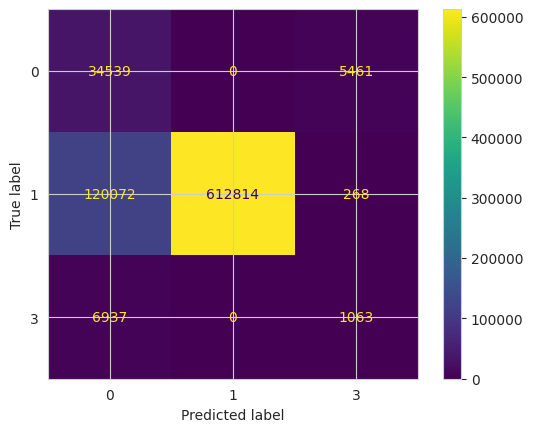

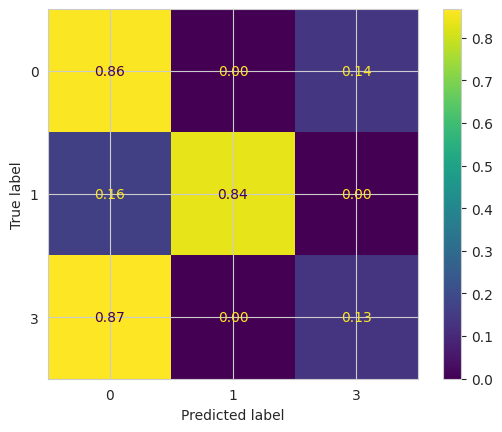

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    f1_score
)

y_true = y_te.to_numpy() if hasattr(y_te, "to_numpy") else np.asarray(y_te)
s1_pred = pred_stage1

pred_final = np.zeros_like(y_true)

attack_pred_mask = (s1_pred == 1)
if attack_pred_mask.any():
    pred_final[attack_pred_mask] = rf_stage2.predict(X_te[attack_pred_mask])

labels = np.array(sorted(np.unique(np.concatenate([y_true, pred_final]))))

print("===== END-TO-END RESULTS =====")
print("Accuracy:", accuracy_score(y_true, pred_final))
print("Balanced accuracy:", balanced_accuracy_score(y_true, pred_final))
print("Macro F1:", f1_score(y_true, pred_final, average="macro", zero_division=0))
print("Weighted F1:", f1_score(y_true, pred_final, average="weighted", zero_division=0))
print(classification_report(y_true, pred_final, labels=labels, zero_division=0))

cm = confusion_matrix(y_true, pred_final, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.show()

cm_norm = confusion_matrix(y_true, pred_final, labels=labels, normalize="true")
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp2.plot(values_format=".2f")
plt.show()
